In [9]:
import numpy as np
import pandas as pd
import pickle as pkl
from tqdm.notebook import tqdm as tqdm
from matplotlib import pyplot as plt
from collections import Counter

In [10]:
empty_desc = np.zeros(768)
empty_title = np.zeros(768)

class Video:
    def __init__(self, uid): 
        self.uid = uid
        if uid not in video_db:
            self.title, self.tags, self.description, self.category, self.channel_title = None, None, None, None, None
            self.title_emb, self.tags_emb, self.description_emb = empty_title, [], empty_desc
            return

        vs = video_db[uid]['snippet']
        self.title = vs['title']
        self.tags = vs.get('tags', [])
        self.description = vs['description']
        self.category = vs['categoryId']
        self.channel_title = vs['channelTitle']
        
        self.title_emb = video_db[uid]['embeddings']['title']
        self.tags_emb = video_db[uid]['embeddings']['tags']
        self.description_emb = video_db[uid]['embeddings']['description']

    def __repr__(self):
        if self.title is None:
            return 'Video not found'
        return self.title
    
    def __str__(self):
        if self.title is None:
            return 'Video not found'
        return self.title
    
    def __hash__(self):
        return hash(self.uid)
    
def get_id(url):
    if len(url.split('v=')) <= 1:
        return None
    url = url.split('v=')[1]
    url = url.split('&')[0]
    return url

def decode_upnext(urls):
    urls = eval(urls.decode('utf-8'))
    ids = []
    for u in urls:
        ids.append(get_id(u))
    return ids

In [11]:
sessions = pd.read_pickle('all_sessions')
video_db = pd.read_pickle('video-dump-with-embeddings+transcript')

In [12]:
# Single Step Data (only access to this video)
ss_session = []
for session in tqdm(sessions):
    for video, next_video, in zip(session[:-1], session[1:]):
        video['selected'] = next_video['url']
        ss_session.append(video)


data = pd.DataFrame(ss_session)
data['url'] = data['url'].apply(get_id)
data['selected'] = data['selected'].apply(get_id)
data['upnext_content'] = data['upnext_content'].apply(decode_upnext)
data = data[['url', 'upnext_content', 'selected']]
data.columns = ['video', 'upnext', 'selected']
data.head()

  0%|          | 0/6762 [00:00<?, ?it/s]

,video,upnext,selected
0,489B7RNudAQ,"[ZOZyo6YOAu4, VtYi8AR11WM, Q32BGQmVLJ0, h1BsKI...",Q32BGQmVLJ0
1,jnXeE4TY2so,"[MeH-4wEuvZs, h1BsKIP4uYM, dqbyJIKLxok, VX4n8w...",HtyVbMZegn4
2,NQPNRwpGWXc,"[2PopspP_DbI, VPrrIGxjubI, 4s2ynUAJ5ZU, dEk8Hb...",VPrrIGxjubI
3,8tsnuvfMmtc,"[4iYl9oSjffQ, mTHedRdHJgk, aeWyp2vXxqA, 6S7VkI...",aeWyp2vXxqA
4,LcW4MCa5YCQ,"[-TgFz3qmE9U, 9scfWN6aXaU, O7VaXlMvAvk, h1BsKI...",z0Xpye7Ltlo


In [13]:
video_sessions = []
ss_sessions = data.to_dict('records')

for session in tqdm(ss_sessions):
    video_session = {}
    v = Video(session['video'])
    video_session['video'] = Video(session['video'])
    video_session['upnext'] = []
    for upnext in session['upnext']:
        video_session['upnext'].append(Video(upnext))
    video_session['selected'] = Video(session['selected'])
    video_sessions.append(video_session)

  0%|          | 0/8563 [00:00<?, ?it/s]

# Similarities between video and selected

In [14]:
# compute cosine similarity between two title embeddings

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def cosine_sim(a, b):
    return cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))[0][0]

def cosine_sim_matrix(a, b):
    return cosine_similarity(a, b)

In [15]:
def tag_cosine_sim(a, b):
    if not len(a) or not len(b):
        return 0
    
    i = cosine_sim_matrix(a, b).flatten()
    return np.mean(i)

In [36]:
# similarities = {'title': [], 'tags': [], 'description': []}

for session in tqdm(video_sessions):
    playing = session['video']
    selected = session['selected']
    suggested = session['upnext']

    title_similarity = dict()
    description_similarity = dict()

    # title
    sims = []
    for video in suggested:
        sims.append(cosine_sim(playing.title_emb, video.title_emb))
    title_similarity['suggested'] = sims
    title_similarity['selected'] = cosine_sim(playing.title_emb, selected.title_emb)

    # description
    sims = []
    for video in suggested:
        sims.append(cosine_sim(playing.description_emb, video.description_emb))
    description_similarity['suggested'] = sims
    description_similarity['selected'] = cosine_sim(playing.description_emb, selected.description_emb)
    
    similarities['description'].append(description_similarity)
    similarities['title'].append(title_similarity)

  0%|          | 0/8563 [00:00<?, ?it/s]

In [7]:
# similarities = {'title': [], 'tags': [], 'description': []}

for session in tqdm(video_sessions):
    playing = session['video']
    selected = session['selected']
    suggested = session['upnext']

    tags_similarity = dict()

    sims = []
    for video in suggested:
        sims.append(tag_cosine_sim(playing.tags_emb, video.tags_emb))
    tags_similarity['suggested'] = sims
    tags_similarity['selected'] = tag_cosine_sim(playing.tags_emb, selected.tags_emb)
    similarities['tags'].append(tags_similarity)

NameError: name 'video_sessions' is not defined

In [16]:
def rank(l, e):
    if e == 0:
        return -1
    return sorted(l, reverse=True).index(e)

## Title

In [100]:
title_sims = []
ranks = []
for sim in similarities['title']:
    ranks.append(rank(sim['suggested'], sim['selected']))
    title_sims.append(sim['selected'])

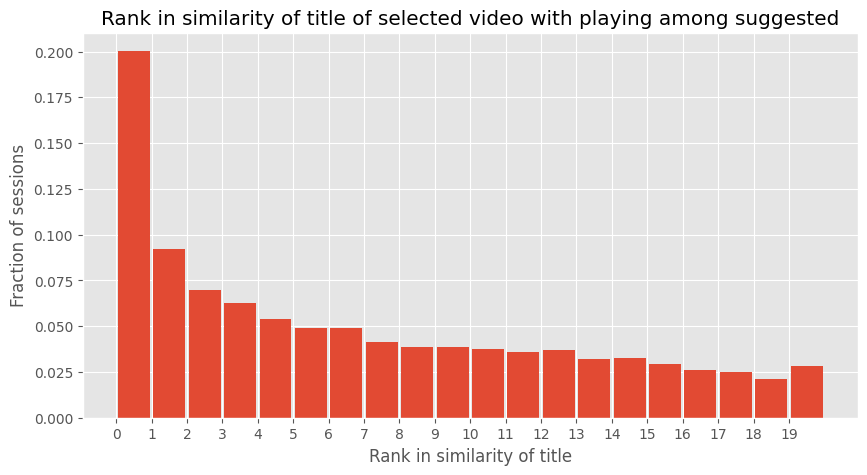

Baseline accuracy: 0.2


In [127]:
ranks = np.array(ranks)
ranks[ranks > 20] = 20

plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.hist(ranks, bins=20, rwidth=.9, density=True)
plt.xticks(np.arange(20), np.arange(20))
plt.xlabel('Rank in similarity of title')
plt.ylabel('Fraction of sessions')
plt.title('Rank in similarity of title of selected video with playing among suggested')
plt.show()

print('Baseline accuracy:', round(Counter(ranks)[0]/len(video_sessions), 3))

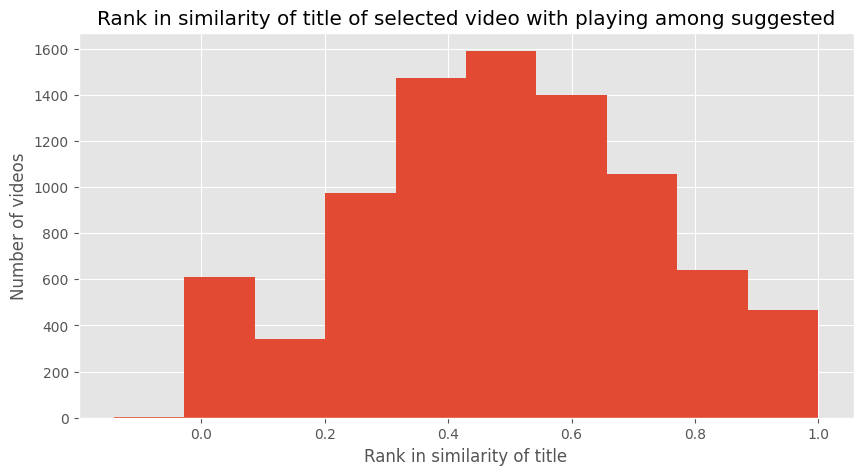

In [104]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.hist(title_sims)
# plt.xticks(np.arange(20), np.arange(20))
plt.xlabel('Rank in similarity of title')
plt.ylabel('Number of sessions')
plt.title('Rank in similarity of title of selected video with playing among suggested')
plt.show()

# Descriptions

In [111]:
description_sims = []
ranks = []
for sim in similarities['description']:
    ranks.append(rank(sim['suggested'], sim['selected']))
    description_sims.append(sim['selected'])

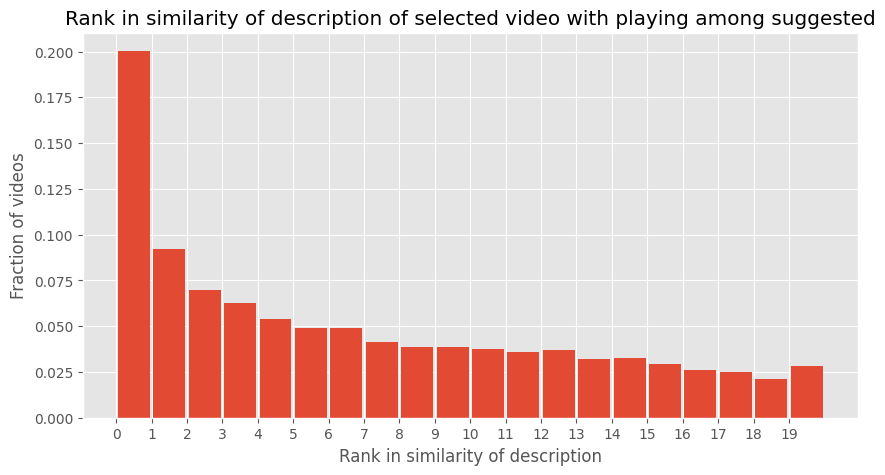

Baseline accuracy: 0.2


In [126]:
ranks = []
for sim in similarities['description']:
    ranks.append(rank(sim['suggested'], sim['selected']))

ranks = np.array(ranks)
ranks[ranks > 20] = 20

plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.hist(ranks, bins=20, rwidth=0.9, density=True)
plt.xticks(np.arange(20), np.arange(20))
plt.xlabel('Rank in similarity of description')
plt.ylabel('Fraction of videos')
plt.title('Rank in similarity of description of selected video with playing among suggested')
plt.show()

print('Baseline accuracy:', round(Counter(ranks)[0]/len(video_sessions), 3))

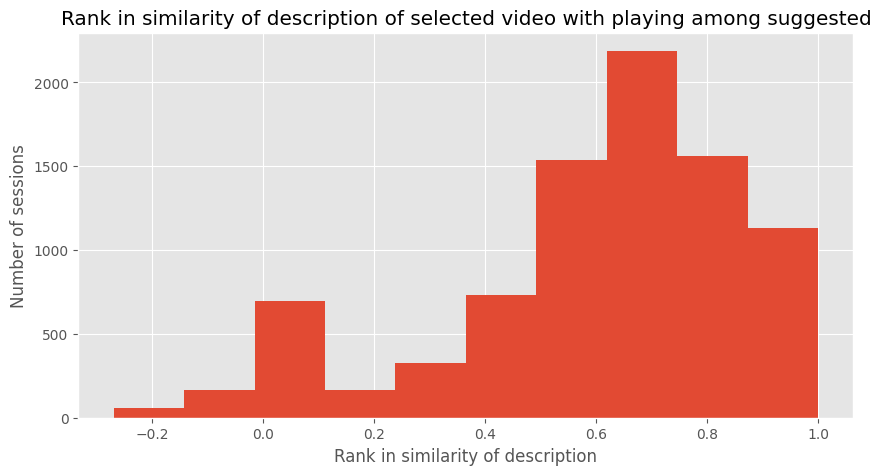

In [116]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.hist(description_sims)
# plt.xticks(np.arange(20), np.arange(20))
plt.xlabel('Rank in similarity of description')
plt.ylabel('Number of sessions')
plt.title('Rank in similarity of description of selected video with playing among suggested')
plt.show()

# Tags

In [171]:
tags_sims = []
ranks = []
for sim in similarities['tags']:
    ranks.append(rank(sim['suggested'], sim['selected']))
    tags_sims.append(sim['selected'])

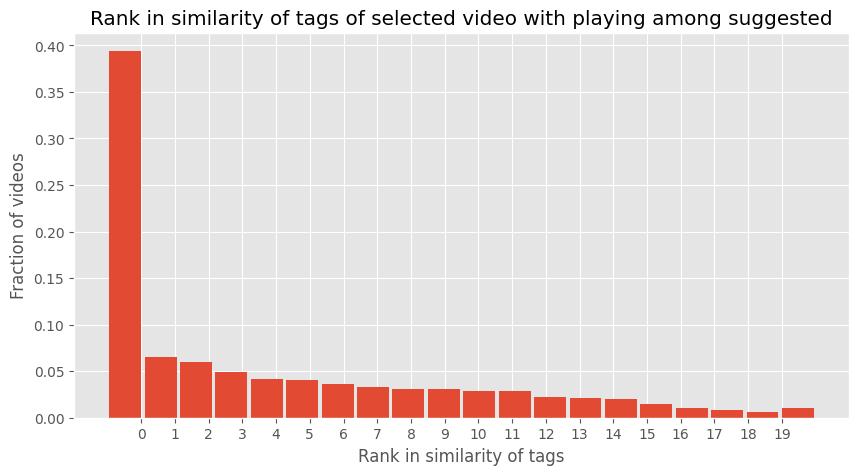

Baseline accuracy: 0.112


In [175]:
ranks = []
for sim in similarities['tags']:
    ranks.append(rank(sim['suggested'], sim['selected']))

ranks = np.array(ranks)
ranks[ranks > 20] = 20

plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.hist(ranks, bins=20, rwidth=0.9, density=True)
plt.xticks(np.arange(20), np.arange(20))
plt.xlabel('Rank in similarity of tags')
plt.ylabel('Fraction of videos')
plt.title('Rank in similarity of tags of selected video with playing among suggested')
plt.show()

print('Baseline accuracy:', round(Counter(ranks)[0]/len(video_sessions), 3))

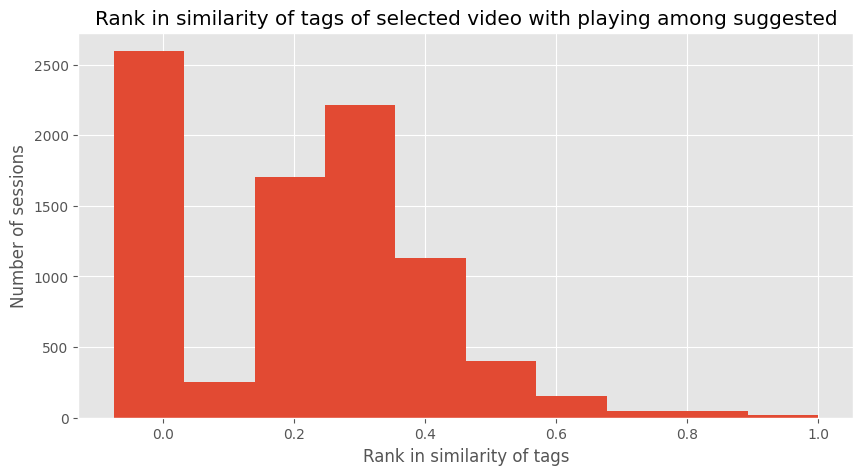

In [176]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.hist(tags_sims)
# plt.xticks(np.arange(20), np.arange(20))
plt.xlabel('Rank in similarity of tags')
plt.ylabel('Number of sessions')
plt.title('Rank in similarity of tags of selected video with playing among suggested')
plt.show()

In [ ]:
# 

# Linear regression 

In [32]:
# linear regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score



In [90]:
def video_ranked(l, e):
    l = [i.title for i in l]
    return l.index(e.title)

In [92]:
X = []
K = []
Ky = []
y = []
for session in video_sessions:
    x = session['video'].title_emb
    suggested = []
    for video in session['upnext']:
        suggested.append(video.title_emb)
    K.append(suggested)
    x += np.mean(suggested, axis=0).shape
    y.append(session['selected'].title_emb)
    
    Ky.append(video_ranked(session['upnext'], session['selected']))
    X.append(x)

In [104]:
y = np.array(y)
X = np.array(X)
model = LinearRegression().fit(X, y)
model.score(X, y)

0.13427832507008172

In [130]:
correct = 0
for i in range(len(X)):
    x = X[i]
    k = K[i]

    yy = model.predict([x])[0]

    sims = []

    for suggested in k:
        sims.append(cosine_sim(yy, suggested))
            
    # argmax 

    if sum(np.array(sims) > 0.8) > 2:
        continue

    if sims[Ky[i]] > 0.5:
        correct += 1

    

In [132]:
correct/len(X)

0.11070886371598739

# Single video model

In [26]:
# append numpy arrays

(1536,)

In [ ]:
# train neural network
from sklearn.neural_network import MLPRegressor
m = MLPRegressor(hidden_layer_sizes=(200, 200, 200), max_iter=1000)
m.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=1000)

In [101]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [119]:
# basic keras neural network with hidden layers

# train neural network

from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD


model = Sequential()
model.add(Dense(1200, activation='relu', input_dim=1536))
model.add(Dropout(0.2))
model.add(Dense(800, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

sgd = SGD(lr=0.02, decay=1e-6, momentum=0.95)
model.compile(loss='mean_squared_error',
                optimizer=sgd,
                metrics=['AUC'])

model.fit(X_train, y_train,
            epochs=20,
            batch_size=128)


/home/data/hussam/miniconda3/envs/jup/lib/python3.10/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1002/1002 [==============================] - 29s 28ms/step - loss: 0.0578 - auc: 0.5216
Epoch 2/20
1002/1002 [==============================] - 28s 28ms/step - loss: 0.0574 - auc: 0.5216
Epoch 3/20
1002/1002 [==============================] - 28s 28ms/step - loss: 0.0574 - auc: 0.5216
Epoch 4/20
1002/1002 [==============================] - 40s 40ms/step - loss: 0.0574 - auc: 0.5216
Epoch 5/20
1002/1002 [==============================] - 45s 45ms/step - loss: 0.0574 - auc: 0.5216
Epoch 6/20
1002/1002 [==============================] - 47s 47ms/step - loss: 0.0574 - auc: 0.5216
Epoch 7/20
1002/1002 [==============================] - 44s 44ms/step - loss: 0.0574 - auc: 0.5216
Epoch 8/20
1002/1002 [==============================] - 28s 28ms/step - loss: 0.0574 - auc: 0.5216
Epoch 9/20
1002/1002 [==============================] - 29s 29ms/step - loss: 0.0574 - auc: 0.5216
Epoch 10/20
1002/1002 [==============================] - 29s 29ms/step - loss: 0.0574 - auc: 0.5216
Epoch 11/

In [106]:
score = model.evaluate(X_test, y_test, batch_size=128)

251/251 [==============================] - 2s 6ms/step - loss: 0.0855 - auc: 0.5654


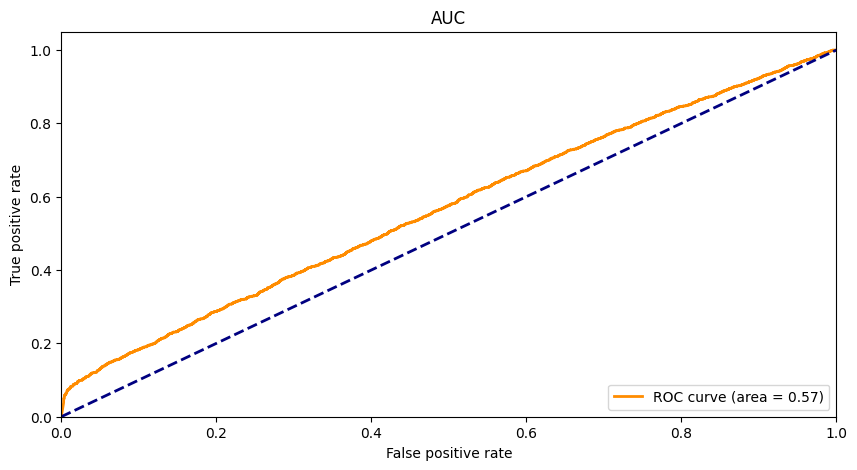

In [117]:
# plot auc

In [116]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.2, 1, 0)

from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred))

# recall and precision
from sklearn.metrics import recall_score, precision_score

print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.11241976693462954
0.9575371549893843
0.0597153260509765


In [94]:
y_pred_proba = m.predict(X_test)
# convert to classes with threshold 0.5
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

In [109]:
# m.score(X, Y)
from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred))

# recall and precision
from sklearn.metrics import recall_score, precision_score

print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.14065817409766454
0.19879969992498125


In [72]:
# single label output
X = []
Y = []
for session in video_sessions:
    playing = session['video'].title_emb
    for video in session['upnext']:
        if video.title == session['selected'].title:
            y = 1
        else:
            y = 0
        x = video.title_emb
        X.append(np.append(playing, x))
        Y.append(y)

In [ ]:
# multi label output
X = []
Y = []
for session in video_sessions:
    x = []
    y = []
    playing = session['video'].title_emb
    x = playing
    for video in session['upnext']:
        if video.title == session['selected'].title:
            y.append(1)
        else:
            y.append(0)

        x = np.append(x, video.title_emb)
    X.append(x)
    Y.append(y)

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

In [81]:
m = LogisticRegression(class_weight={1:0.9, 0:0.1}, max_iter=1000)
m.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.1, 1: 0.9}, max_iter=1000)

In [82]:
m.score(X_test, y_test)

0.8636150893943649

In [88]:
m.predict(X_test).sum()

3079

In [91]:
# calculate f1score

ValueError: Classification metrics can't handle a mix of binary and continuous targets